---
title: "SWD Properties"
format:
  html:
    code-fold: true
output-file: properties.html

---

In [49]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [50]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np

In [51]:
#| output: False
from ids_finder.utils.basic import load_catalog

catalog = load_catalog('../../')

[10/27/23 01:09:43] WARNING  /Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/ke ]8;id=661388;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=916906;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             dro/io/partitioned_dataset.py:200: KedroDeprecationWarning:                           
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

Connect `python` with `R` kernel

In [52]:
%load_ext rpy2.ipython
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [53]:
from ids_finder.candidates import cIDsDataset

sta_dataset = cIDsDataset(sat_id="STA", tau=60, ts=1, catalog=catalog)
jno_dataset = cIDsDataset(sat_id="JNO", tau=60, ts=1, catalog=catalog)
thb_candidate = cIDsDataset(sat_id="THB", tau=60, ts=1, catalog=catalog)

                    INFO     Loading data from 'candidates.STA_ts_1s_tau_60s'                   ]8;id=628891;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=486497;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'STA.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=646415;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=342931;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.JNO_ts_1s_tau_60s'                   ]8;id=376253;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=1830;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'JNO.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=800714;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=124293;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'candidates.THB_ts_1s_tau_60s'                   ]8;id=250134;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7716;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

                    INFO     Loading data from 'THB.primary_mag_ts_1s' (PartitionedDataset)...  ]8;id=136495;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=484993;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [87]:
from ids_finder.utils.basic import filter_tranges_df
from beforerr.basics import pmap
from ids_finder.utils.analysis import link_coord2dim

In [88]:
thb_inter_state_sw: pl.LazyFrame = catalog.load('thb.inter_state_sw')
start, end = thb_inter_state_sw.select(['start', 'end']).collect()

thb_sw_dataset = cIDsDataset(
    sat_id="THB", tau=60, ts=4, catalog=catalog,
    candidates = filter_tranges_df(thb_candidate.candidates, (start, end)), 
    data = filter_tranges_df(thb_candidate.data.collect(), (start, end)).lazy()
)

[10/27/23 01:16:50] INFO     Loading data from 'thb.inter_state_sw' (LazyPolarsDataset)...      ]8;id=592835;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=965660;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [89]:
all_datasets = [sta_dataset, jno_dataset, thb_sw_dataset]

In [90]:
all_candidates_l0 : pl.DataFrame = pl.concat(
    all_datasets | pmap(lambda x: x.candidates),
    how="diagonal",
)

Some extreme values are present in the data. We will remove them.

In [92]:
all_candidates_l0.sort("j0", descending=True)[["time", "d_star", "duration", "j0", "v_mn", "Q_mva"]]

time,d_star,duration,j0,v_mn,Q_mva
datetime[ns],f64,duration[ns],f64,f64,f64
2012-07-25 10:54:30,152023.367594,6s 1ns,1.1500e6,105.196482,19.560181
2011-11-10 16:38:30,136518.198794,2s 999ns,342414.204774,317.26993,1.630179
2015-10-24 10:13:00,54827.028107,2s 999ns,275250.678733,158.509919,21.755013
2012-03-13 18:17:30,0.886776,11s,1704.075697,0.41411,6.754985
2012-02-27 19:13:30,1.673386,5s,653.386449,2.038056,2.750127
2014-08-04 22:20:30,5.346607,6s,393.479096,10.813013,65.380586
2016-06-26 15:48:30,3.948529,4s,256.805332,12.235493,11.681011
2013-03-20 14:04:00,1.898604,4s,207.544988,7.279678,2.762354
2013-04-11 20:50:00,0.971561,4s,189.710939,4.075378,171.456842


## Thickness

In [93]:
def process_candidates(df: pl.DataFrame, avg_window="30d"):
    time_col = "time"

    candidate = (
        df.filter(
            pl.col("d_star") < 10, # exclude JUNO extreme values
            pl.col("j0") < 100, # exclude JUNO extreme values, which is caused by small `v_mn` mostly
        )
        .sort(time_col)
        .group_by_dynamic(time_col, every=avg_window, by="sat")
        .agg(cs.numeric().mean(), id_count=pl.count())
        .filter(pl.col("id_count") > 50)  # filter out JUNO extreme large thickness
        .sort(time_col)
        .upsample(time_col, every=avg_window, by="sat", maintain_order=True)
        .with_columns(pl.col("sat").forward_fill())
    )
    return candidate

In [94]:
def filter_before_jupiter(df: pl.DataFrame):
    return df.filter(pl.col("time") < pd.Timestamp("2016-05-01"))

In [95]:
all_candidates_l1: pl.DataFrame = all_candidates_l0.pipe(filter_before_jupiter).pipe(process_candidates).pipe(link_coord2dim)

In [96]:
vars = ['time', 'sat', 'id_count', 'j0', 'L_mn', 'L_mn_norm']
inspect_df = all_candidates_l1[vars]
inspect_df.describe()

describe,time,sat,id_count,j0,L_mn,L_mn_norm
str,str,str,f64,f64,f64,f64
"""count""","""172""","""172""",172.0,172.0,172.0,172.0
"""null_count""","""0""","""0""",19.0,19.0,19.0,19.0
"""mean""",null,null,1137.562092,1.923627,2994.36727,22.687238
"""std""",null,null,854.126438,1.059845,530.198758,8.850838
"""min""","""2011-08-24 00:…","""JNO""",152.0,0.229362,1882.120187,7.074407
"""25%""",null,null,449.0,0.795284,2616.749013,14.498058
"""50%""",null,null,525.0,2.079207,2867.112557,22.811545
"""75%""",null,null,2123.0,2.62338,3278.031527,29.221109
"""max""","""2016-04-29 00:…","""THB""",2647.0,4.556992,4572.357421,44.030654


Note since want different y-axis titles (labels) for each facet, not different facet titles, it is not clear how to do this with `facet_wrap` after `pivot_longer`. Also these are different units, so it is better to plot them separately and combine them together.

In [97]:
%%R
plot_thickness <- function(df, x_var = "time") {
  
  # Plot for L_mn
  p1 <- ggplot(df, aes_string(x=x_var, y="L_mn", color="sat", linetype="sat")) + 
    geom_line() + geom_point() +
    labs(y = "Thickness (km)")
      
  # Plot for L_mn_norm
  p2 <- ggplot(df, aes_string(x=x_var, y="L_mn_norm", color="sat", linetype="sat")) + 
    geom_line() + geom_point() +
    labs(y = "Normalized thickness (d_i)")

  # Customize plot elements
  common_elements <- list(
    labs(x = x_var, color="Satellites", linetype="Satellites"),
    theme_pubr(base_size = 16),
    theme(legend.text = element_text(size=16))
  )
  # Combine the plots vertically  
  p1 <- ggpar(p1 + common_elements, xlab=FALSE)
  p2 <- ggpar(p2 + common_elements, legend = "none")
  p <- p1 / p2
  
  return(p)
}


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 19 rows containing missing values (`geom_point()`). 
2: Removed 19 rows containing missing values (`geom_point()`). 
3: Removed 19 rows containing missing values (`geom_point()`). 
4: Removed 19 rows containing missing values (`geom_point()`). 
5: Removed 19 rows containing missing values (`geom_point()`). 
6: Removed 19 rows containing missing values (`geom_point()`). 


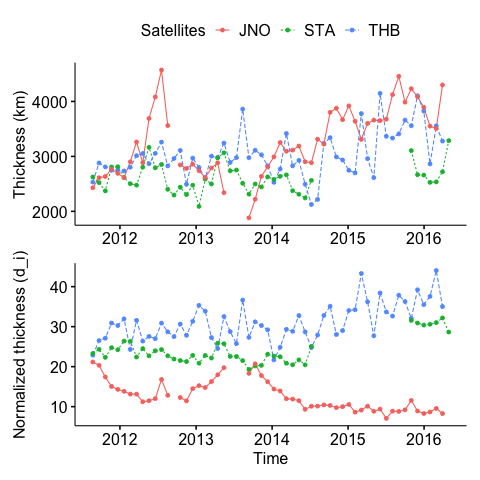

In [98]:
%%R -i all_candidates_l1 -c conv_pl
p <- plot_thickness(all_candidates_l1)
p <- ggpar(p, xlab="Time")
print(p)

save_plot("thickness_time")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 12 warnings (use warnings() to see them)


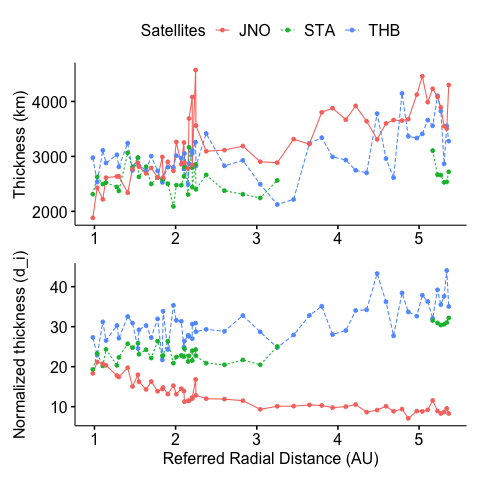

In [99]:
%%R
p <- plot_thickness(all_candidates_l1, x_var="ref_radial_distance")
p <- ggpar(p, xlab="Referred Radial Distance (AU)")
print(p)

save_plot("thickness_r")

## Current intensity

In [100]:
%%R
plot_j <- function(df, x_var = "time") {
  
  # Plot for L_mn
  p1 <- ggplot(df, aes_string(x=x_var, y="j0", color="sat", linetype="sat")) + 
    geom_line() + geom_point() +
    labs(y = "J (nA/m^2)")
      
  # Plot for L_mn_norm
  p2 <- ggplot(df, aes_string(x=x_var, y="j0_norm", color="sat", linetype="sat")) + 
    geom_line() + geom_point() +
    labs(y = "Normalized J (J_A)")

  # Customize plot elements
  common_elements <- list(
    labs(x = x_var, color="Satellites", linetype="Satellites"),
    theme_pubr(base_size = 16),
    theme(legend.text = element_text(size=16))
  )
  # Combine the plots vertically  
  p1 <- ggpar(p1 + common_elements, xlab=FALSE)
  p2 <- ggpar(p2 + common_elements, legend = "none")
  p <- p1 / p2
  
  return(p)
}


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 19 rows containing missing values (`geom_point()`). 
2: Removed 19 rows containing missing values (`geom_point()`). 
3: Removed 19 rows containing missing values (`geom_point()`). 
4: Removed 19 rows containing missing values (`geom_point()`). 
5: Removed 19 rows containing missing values (`geom_point()`). 
6: Removed 19 rows containing missing values (`geom_point()`). 


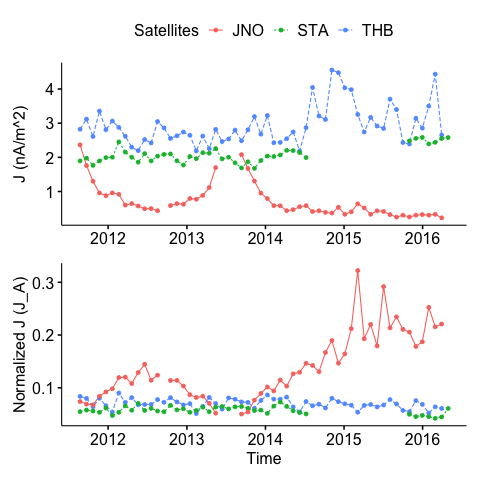

In [101]:
%%R
p <- plot_j(all_candidates_l1, x_var="time")
p <- ggpar(p, xlab="Time")
print(p)

save_plot("current_time")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 12 warnings (use warnings() to see them)


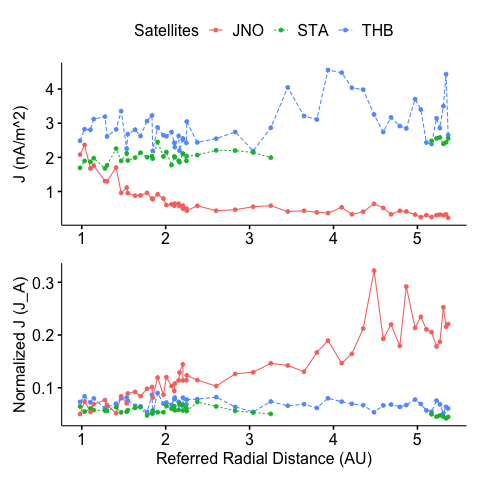

In [102]:
%%R
p <- plot_j(all_candidates_l1, x_var="ref_radial_distance")
p <- ggpar(p, xlab="Referred Radial Distance (AU)")
print(p)

save_plot("current_r")